# Creating a Mesh Structure and Data


* import the package
* build a new instance of the class which requaires :
  1. Number of cells in each direction as a tuple with 3 integers
  2. Starting point of mesh in each direction as a tuple with 3 floating-point values
  3. Ending of mesh in each direction as a tuple with 3 floating-point values
  4. Detrimining the system of coordinate as an string, with two possible values  (__"SPH"__ , or __"CAR"__)




In [ ]:
import numpy as np
from DataSet import DataSet as DS

nx, ny, nz = 35, 40, 30  # Number of Cells in x-, y-, and z-direction
x0, y0, z0 = 0.0, 0.0, 0.0  # starting values of mesh in x-, y-, and z-direction
x1, y1, z1 = 1.0, 2.0, 5.0  # ending values of mesh in x-, y-, and z-direction

ds1 = DS(SystemOfCoords="CAR", NCell=(nx, ny, nz), startval=(x0, y0, z0), endval=(x1, y1, z1))

Now the coordinates of all locations in mesh (Cells, Nodes, Faces, and Edges) are calculated and stored in __ds1__ object.
In order to create a parameter on these locations, one first needs to define a function to evaluate the parameter on coorspoinding location (in this case 3 components of magnetic field)

In [ ]:
K1 = 2.0
B0 = 100.0
def BFieldX(Coords):
    return np.exp(- K1 * Coords["Z"]) * np.cos(K1 * Coords["X"])


def BFieldY(Coords):
    return 0.0 * Coords["Y"]


def BFieldZ(Coords):
    return - np.exp(- K1 * Coords["Z"]) * np.sin(K1 * Coords["X"])

Then by passing the paramter's name, location on mesh and cooresponding function to "Scalar" method, the parameter is evaluted:

In [ ]:
ds1.Scalar("Bx", "FaceX", BFieldX)
ds1.Scalar("By", "FaceY", BFieldY)
ds1.Scalar("Bz", "FaceZ", BFieldZ)

To extract magnetic vector potential first a dummy function must be defined to allocate the arrays for
"A", then using $A_{z} = 0$ gauge:

Now, $\vec{A}$ can be evaluted using  𝐴𝑧=0  gauge:

In [ ]:
ds1.ExtractAFromBFace("Bx", "By", "Bz", "Ax", "Ay", "Az")

Now, to check if exctraction of $\vec{A}$ is done correctly and $\vec{B}$ is divergance-free, one can calculate $\vec{B}$ from $\vec{A}$, calculate $\nabla . \vec{B}$, store the results in a file, then plot the results: 

In [ ]:
ds1.CurlEdgeToFace("Ax", "Ay", "Az", "BFx", "BFy", "BFz")
ds1.DivFace("BFx", "BFy", "BFz", "DivBf")  # using A on Edges and B on Cells

### Calculation of $\vec{J}$ on cell edges using $\vec{B}$ located on cell faces:  

In [ ]:
ds1.CurlFaceToEdge("Bx", "By", "Bz", "Jx", "Jy", "Jz")

### Calcualtion of Lorantz-Force using the average of $\vec{J}$ and $\vec{B}$ on cell-center :

In [ ]:
ds1.AvgFaceToCell("Bx", "By", "Bz", "BXc", "BYc", "BZc")
ds1.AvgEdgeToCell("Jx", "Jy", "Jz", "JXc", "JYc", "JZc")
ds1.Cross("JXc", "JYc", "JZc", "BXc", "BYc", "BZc", "LFx", "LFy", "LFz")

Now we try to transfer $\vec{A}$ to a new mesh and the calculate $\vec{B}$ on the new mesh: 

In [ ]:
nxyz = (30, 35, 29)  # Number of Cells in x-, y-, and z-direction
xyz0 = (0.0, 0.0, 0.0)  # starting values of mesh in x-, y-, and z-direction
xyz1 = (1.0, 2.0, 5.0)  # ending values of mesh in x-, y-, and z-direction
# ds2 = DS(SystemOfCoords="CAR", NCell=nxyz, startval=xyz0, endval=xyz1)
ds2 = DS(SystemOfCoords="CAR", NCell=(nx,ny,nz), startval=(x0,y0,z0), endval=(x1, y1,z1))

In [ ]:
ds1.ToNewMesh(ds2, "Ax", "EdgeX")
ds1.ToNewMesh(ds2, "Ay", "EdgeY")
ds2.Scalar("Az", "EdgeZ", ds2.Adummy)

In [ ]:
ds2.CurlEdgeToFace("Ax", "Ay", "Az", "Bx", "By", "Bz")
ds2.CurlFaceToEdge("Bx", "By", "Bz", "Jx", "Jy", "Jz")
ds2.AvgFaceToCell("Bx", "By", "Bz", "BXc", "BYc", "BZc")
ds2.AvgEdgeToCell("Jx", "Jy", "Jz", "JXc", "JYc", "JZc")
ds2.Cross("JXc", "JYc", "JZc", "BXc", "BYc", "BZc", "LFx", "LFy", "LFz")
# just to remove unnecessary data (averge B and J on cell center) before saveing them in the file 
for varname in ["JXc", "JYc", "JZc", "BXc", "BYc", "BZc"]:
    del ds1.vars[varname]
    del ds2.vars[varname]
ds1.Write2HDF5("InitialStructure.h5")
ds2.Write2HDF5("Extrapolated.h5")

In [ ]:
pwd

# Compare parameters on the original and interpolated meshes assuming exactly same meshing

In [ ]:
for var in ["Ax", "Ay", "Az", "Bx", "By", "Bz", "Jx", "Jy", "Jz"]:
    print(var, np.max(np.abs(ds1.vars[var]["val"] - ds2.vars[var]["val"])))

## So maybe the difference is caused by extraction $\vec{A}$ from $\vec{B}$ in the original mesh, Lets check it out

In [ ]:
for com in ["x", "y", "z"]:
    print(np.max(ds1.vars["BF"+com]["val"] - ds1.vars["B"+com]["val"]))

# Check equations for extraction of $\vec{A}$
As it is obvious $B_{z}$ has considerable difference with the original and $\vec{B} = \nabla \times \vec{A}$ <br>
I expect that by changing the mesh resolution the error of magnetic field component vary with $h^{2}$, in which 
__h__ is the length of cell in each integration / differentiation direction, so now I try reconstructing $\vec{B}$ for different mesh resolution and compare each component at the last cell of interpolation with the original magnetic field

In [20]:
from __future__ import print_function
import numpy as np
from DataSet import DataSet as DS
from scipy.optimize import curve_fit
# %matplotlib widget
import matplotlib.pyplot as plt


K1 = 2.0
B0 = 100.0
def BFieldX(Coords):
    return np.exp(- K1 * Coords["Z"]) * np.cos(K1 * Coords["X"])


def BFieldY(Coords):
    return 0.0 * Coords["Y"]


def BFieldZ(Coords):
    return - np.exp(- K1 * Coords["Z"]) * np.sin(K1 * Coords["X"])

x0, y0, z0 = 0.0, 0.0, 0.0  # starting values of mesh in x-, y-, and z-direction
x1, y1, z1 = 1.0, 2.0, 5.0  # ending values of mesh in x-, y-, and z-direction
nx, ny, nz = 35, 40, 15  # Number of Cells in x-direction, y-direction, and z-direction

NPoint = 60
results = np.empty((NPoint, 2))

for j in range(NPoint):
    results[j, 0] = (nz + j)
    InterTest = DS(SystemOfCoords="CAR", NCell=(nx, ny, (nz + j)), startval=(x0, y0, z0), endval=(x1, y1, z1))
    InterTest.Scalar("Bx", "FaceX", BFieldX)
    InterTest.Scalar("By", "FaceY", BFieldY)
    InterTest.Scalar("Bz", "FaceZ", BFieldZ)
    InterTest.ExtractAFromBFace("Bx", "By", "Bz", "Ax", "Ay", "Az")
    InterTest.CurlEdgeToFace("Ax", "Ay", "Az", "BxE", "ByE", "BzE")
    results[j, 1] = np.abs(InterTest.vars["Bz"]["val"][-1,-1,0] - InterTest.vars["BzE"]["val"][1,1,0])
    print("\rPrepared :: {0:02} with h = {1:23.16e}".format(j, (z1 - z0) / (nz + j)), end='', flush=True)
np.savetxt("Test.dat", results)

Prepared :: 59 with h= 6.7567567567567571e-02

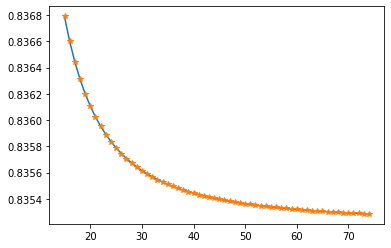

In [21]:
def ErrFunc(n, p0, p1):
    """ Error Estimation of mid-point integration method in
    which __x__ is the number of intervals, in this case, number of cells in Z-Direction
    the actual equation is ::
    
    $ Error <= \frac{M (b - a)^{3}}{24 n^{2}} $
    
    M : is the maximum value fo second derivative of function in integral in the integration interval
    
    a and b : are the limits of integral
    
    n : is the number of intervals used for numerical integration used in mid-point method
    """
    return p0 / (n*n) + p1 

popt, pcov = curve_fit(ErrFunc, results[:, 0], results[:, 1])
plt.figure()
plt.plot(results[:,0], results[:,1])
plt.plot(results[:,0], ErrFunc(results[:,0], *popt), linestyle="none", marker="*" )